{'CYS': ['UGU', 'UGC'], 'ASP': ['GAU', 'GAC'], 'SER': ['UCU', 'UCG', 'UCA', 'UCC', 'AGC', 'AGU'], 'GLN': ['CAA', 'CAG'], 'MET': ['AUG'], 'ASN': ['AAC', 'AAU'], 'PRO': ['CCU', 'CCG', 'CCA', 'CCC'], 'LYS': ['AAG', 'AAA'], 'STOP': ['UAG', 'UGA', 'UAA'], 'THR': ['ACC', 'ACA', 'ACG', 'ACU'], 'PHE': ['UUU', 'UUC'], 'ALA': ['GCA', 'GCC', 'GCG', 'GCU'], 'GLY': ['GGU', 'GGG', 'GGA', 'GGC'], 'ILE': ['AUC', 'AUA', 'AUU'], 'LEU': ['UUA', 'UUG', 'CUC', 'CUU', 'CUG', 'CUA'], 'HIS': ['CAU', 'CAC'], 'ARG': ['CGA', 'CGC', 'CGG', 'CGU', 'AGG', 'AGA'], 'TRP': ['UGG'], 'VAL': ['GUA', 'GUC', 'GUG', 'GUU'], 'GLU': ['GAG', 'GAA'], 'TYR': ['UAU', 'UAC']}


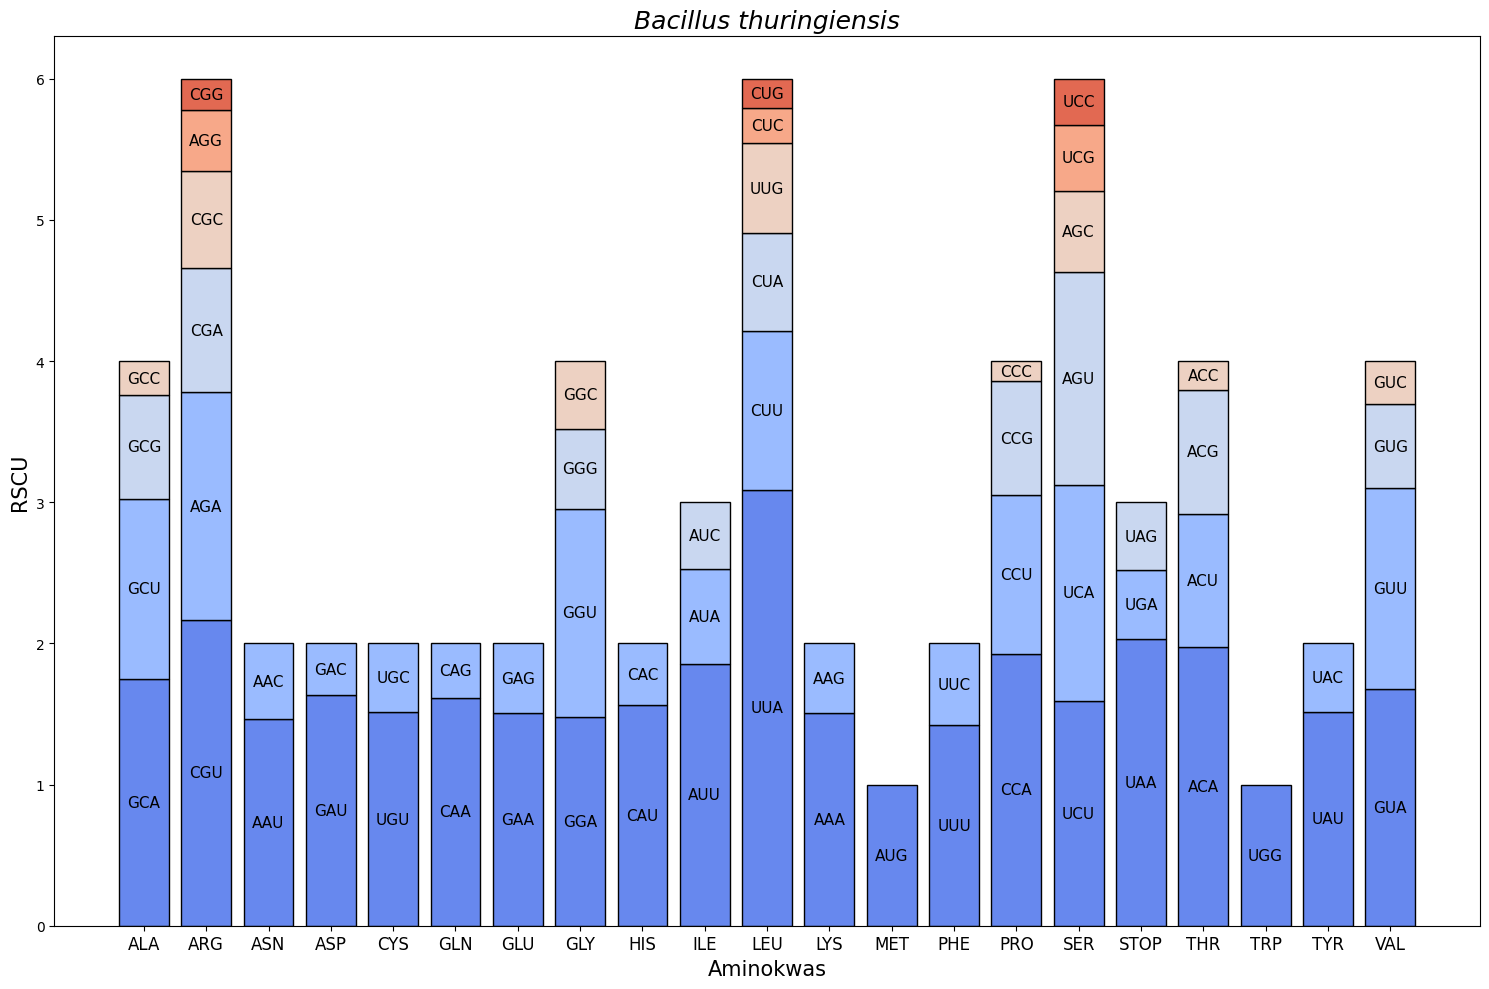

In [2]:
import os
from collections import defaultdict
from Bio import SeqIO
from Bio.SeqUtils.CodonUsage import SynonymousCodons
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

synonymousCodons = {aa: [codon.replace('T', 'U') for codon in codons] for aa, codons in SynonymousCodons.items()}

print(synonymousCodons)
file_path = 'C:/Users/seq/cds_from_genomic_thuringiensis.fna'

def load_genome(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        for record in SeqIO.parse(file, "fasta"):
            sequences.append(str(record.seq).replace('T', 'U'))
    return sequences

def calculate_codon_usage(sequences):
    codon_usage = defaultdict(int)
    total_codons = 0
    
    for sequence in sequences:
        for i in range(0, len(sequence) - 2, 3):
            codon = sequence[i:i+3]
            if len(codon) == 3:
                codon_usage[codon] += 1
                total_codons += 1

    for codon in codon_usage:
        codon_usage[codon] /= total_codons

    return codon_usage

def calculate_rscu(codon_usage):
    rscu = defaultdict(float)
    
    for aa, codons in synonymousCodons.items():
        total = sum([codon_usage[codon] for codon in codons])
        n_codons = len(codons)
        for codon in codons:
            if total > 0:
                rscu[codon] = codon_usage[codon] / (total / n_codons)
            else:
                rscu[codon] = 0
    
    return rscu

def create_rscu_dataframe(rscu):
    data = []
    for codon, value in rscu.items():
        amino_acid = None
        for aa, codons in synonymousCodons.items():
            if codon in codons:
                amino_acid = aa
                break
        data.append([amino_acid, codon, value])
    
    df = pd.DataFrame(data, columns=['AminoAcid', 'Codon', 'RSCU'])
    return df

def plot_rscu_distribution(df):
    amino_acids = sorted(df['AminoAcid'].unique())
    codons = df['Codon'].unique()
       
    rscu_dict = {aa: df[df['AminoAcid'] == aa].sort_values(by='Codon')['RSCU'].values for aa in amino_acids}
    codons_dict = {aa: df[df['AminoAcid'] == aa].sort_values(by='Codon')['Codon'].values for aa in amino_acids}

    sorted_rscu_dict = {}
    sorted_codons_dict = {}
    for aa in amino_acids:
        sorted_indices = np.argsort(-rscu_dict[aa])
        sorted_rscu_dict[aa] = rscu_dict[aa][sorted_indices]
        sorted_codons_dict[aa] = codons_dict[aa][sorted_indices]
    
    max_codons_per_acid = len(max(sorted_rscu_dict.values(), key = len))
    colors = sns.color_palette("coolwarm", max_codons_per_acid)
    
    level_colors = {i: colors[i] for i in range(0, max_codons_per_acid)}
    
    fig, ax = plt.subplots(figsize=(15, 10))
    bottom = np.zeros(len(amino_acids))

    for i, aa in enumerate(amino_acids):
        rscu_vals = sorted_rscu_dict[aa]
        for j, rscu_val in enumerate(rscu_vals):
            ax.bar(i, rscu_val, bottom=bottom[i], color=level_colors[j], edgecolor='black')
            bottom[i] += rscu_val
    
    for i, aa in enumerate(amino_acids):
        codon_vals = sorted_codons_dict[aa]
        rscu_vals = sorted_rscu_dict[aa]
        y_offset = 0
        for j, codon in enumerate(codon_vals):
            y_offset += rscu_vals[j]
            ax.text(i, y_offset - rscu_vals[j]/2, codon, ha='center', va='center', fontsize=11, color='black', rotation=0)
      
    ax.set_xlabel('Aminokwas', fontsize=15)
    ax.set_ylabel('RSCU', fontsize=15)
    species_name = 'Bacillus thuringiensis'
    plt.title(species_name, fontstyle='italic', fontsize=18, y=1)
    plt.xticks(rotation=90)
    ax.set_xticks(range(len(amino_acids)))
    ax.set_xticklabels(amino_acids, rotation=0, fontsize=12)    
    plt.tight_layout()
    
sequences = load_genome(file_path)

codon_usage = calculate_codon_usage(sequences)

rscu = calculate_rscu(codon_usage)

rscu_df = create_rscu_dataframe(rscu)

plot_rscu_distribution(rscu_df)

In [24]:
print(rscu_df)

   AminoAcid Codon      RSCU
0        CYS   UGU  1.511066
1        CYS   UGC  0.488934
2        ASP   GAU  1.633050
3        ASP   GAC  0.366950
4        SER   UCU  1.594679
..       ...   ...       ...
59       VAL   GUU  1.424138
60       GLU   GAG  0.490624
61       GLU   GAA  1.509376
62       TYR   UAU  1.512884
63       TYR   UAC  0.487116

[64 rows x 3 columns]
